# Simulation-based inference with Machine Learning

<hr style="border:2px solid gray">

# Index:  <a id='index'></a>
1. [Introduction](#intro)
1. [Learning the likelihood-density ratio with classifiers](#sbi_with_classifiers)
1. [Simple hypothesis test](#simple_hypothesis_test)
1. [Hypothesis test in higher-dimensions (particle spin example)](#complex_hypothesis_test)
1. [Parameter estimation with parametric classifiers](#parameter_estimation)
1. [Further reading](#further_reading)

<hr style="border:2px solid gray">

# 1. Introduction <a id='intro'></a>

In this notebook you will learn how to use Machine Learning (ML) for simulation-based inference (SBI). Let's begin by introducing what this means...

Statistical inference is a key component of the scientific method. It explains how we extract any understanding from the data we collect. As you have learnt from your statistics lectures, the **likelihood function** holds the key to inference. 

Let's say we perform an experiment $N_{obs}$ times and observe the data set $\mathcal{D} = \{x_i\}^{N_{obs}}_{i=1}$, where $x \in \mathbb{R}^d$ is the vector of features describing the data of dimension $d$. We have a theoretical model, defined by parameters $\theta$, which describes the data. In order to infer the values of $\theta$ from the data, we need the (conditional) probability density: $p(x|\theta)$. The **likelihood** is then constructed as the product of the densities over the observed data:

$$ 
p(\mathcal{D}|\theta) = \prod^{N_{obs}}_{x_i \in \mathcal{D}} p(x_i|\theta) 
$$

This tells us the probability of observing dataset $\mathcal{D}$ given $\theta$. There are then two paradigms for inference:

* <u>**Frequentist inference**</u>: the interpretation here is over hypothetical repetitions of the experiment i.e. probability is the fraction of experiments under which the true value of $\theta$ would be included in the estimator’s confidence interval. For this, we construct a test-statistic $t_\theta$, and compare the observed value of the test-statistic to distributions under different values of $\theta$. The Neyman-Pearson lemma tells us that (for a simple hypothesis test) the most powerful test-statistic is the log-likelihood ratio:

    $$
    t_\theta = -\ln{\frac{p(\mathcal{D}|\theta)}{p(\mathcal{D}|\theta_0)}}
    $$

    where $\theta_0$ is a reference value of the parameter vector $\theta$.

* <u>**Bayesian inference**</u>: the interpretation here is over degrees of belief about parameter values. We use Bayes Theorem to estimate the posterior density:

    $$
    p(\theta|\mathcal{D}) = \frac{p(\mathcal{D}|\theta)p(\theta)}{p(\theta)}
    $$

    from which we build credible intervals for parameters as a function of the data.

Both paradigms rely on the likelihood: $p(\mathcal{D}|\theta)$. This notebook has a frequentist flavour (put together by a particle physicist), but there is nothing stopping you applying these ideas in a Bayesian formalism.

## Intractable likelihoods

For many scientific domains, we are no longer in the regime of simple models with analytic (tractable) likelihoods. The systems that we are trying to model become increasingly complex with many unobserved (latent) variables, $z$. Take disease modelling over a population:

![disease_modelling](disease_modelling.png)

We need to model the effect of social mixing, mask wearing, level of caution etc (latent variables) in order to infer something meaningful about the data. 

This crucially cannot be done analytically. The likelihood becomes a complicated integral over all possible trajectories through latent space:

$$
p(\mathcal{D}|\theta) = \prod^{N_{obs}}_{x_i \in \mathcal{D}} \int dz \,p(x_i|\theta,z) 
$$

How can we approximate this intractable likelihood? Answer: **Simulation**.

We can use (stochastic) simulators to generate synthetic data under different model parameters $\theta$. These simulators are typically very complex in order to encapsulate all the underlying physics. **Simulation-based inference** (SBI) refers to the comparison of the synthetic data to the observed data, in order to infer something about $\theta$.

## Simulation-based inference

There are two traditional approaches to SBI:

* Approximate Bayesian Computation (ABC): which you have already covered.

* Probability density estimation using the simulated (synthetic) data via histogramming or kernel-density estimation.

Over recent years, scientists across many disciplines have turned to Machine Learning (ML) for SBI. The recent boom has lead to the development of a plethora of ML techniques, most of which cannot be covered in this tutorial. Instead, we will lay the foundations by showing how a simple ML classifer can be used for hypothesis testing, and later parameter estimation. This (in theory) will help you bridge the gap between your statistics and ML lectures. If you are interested and want to delve deeper into this fast-growing topic, we have added a [Further reading](#further_reading) section at the end of this notebook.

<hr style="border:2px solid gray">

# 2. Learning the likelihood ratio with classifiers <a id='sbi_with_classifiers'></a>

As mentioned in the previous section, we will show how to perform SBI with ML classifiers.

<div style="background-color:#0000">

Binary classifiers are tasked with discriminating between two hypotheses: $\mathcal{H}_0$ and $\mathcal{H}_1$. They are trained by minimising the binary cross-entropy (BCE) loss function:

$$
\mathcal{L}[f] = -\frac{1}{N} \sum^{N}_{i=1} y_i \ln{f(x_i)} + (1-y_i)\ln{(1-f(x_i))}
$$

where the sum is over $N$ samples $x_i$ drawn from the (conditional) probability densities $p(x|\mathcal{H}_0)$ or $p(x|\mathcal{H}_1)$ with assigned labels $y_i=0$ or $y_i=1$, respectively. Note, for SBI these samples are produced with the simulator.

The quantity $f(x_i)$ is the classifier decision function (i.e. the output of the classifier). The optimal decision function (in the infinite sample limit i.e. as $N \rightarrow \infty$) which minimises the (BCE) loss function is:

$$
f(x_i) = \frac{p(x_i|\mathcal{H}_1)}{p(x_i|\mathcal{H}_0)+p(x_i|\mathcal{H}_1)}
$$

assuming that the two hypotheses are equally represented in the training data. 

It is important to note that our trained classifier $\hat{f}(x_i)$ will be an estimator of the optimal decision function: $\hat{f}(x_i) \approx f(x_i)$. For a classification task, this will just lead to a mis-labelling of the data. However, for inference, it can lead to a bias in our measurement. Hence, we take great care in validating our SBI ML algorithms when applied in real-world scenarios (see [Further reading](#further_reading)).

With a simple re-arranging known as the likelihood-ratio trick [1], we arrive at an approximation of the (conditional) probability density ratio between the two hypotheses for a single sample $x_i$:

$$
\frac{\hat{f}(x_i)}{1-\hat{f}(x_i)} \approx \frac{p(x_i|\mathcal{H_1})}{p(x_i|\mathcal{H_0})}.
$$

The likelihood ratio (which is what we want for Frequentist inference) is then constructed by taking the product of the probability density ratios for all samples in the observed data set. 

$$
\frac{p(\mathcal{D}|\mathcal{H}_0)}{p(\mathcal{D}|\mathcal{H}_1)} = \prod^{N_{obs}}_{x_i \in \mathcal{D}} \frac{p(x_i|\mathcal{H_1})}{p(x_i|\mathcal{H_0})} \approx \prod^{N_{obs}}_{x_i \in \mathcal{D}} \frac{\hat{f}(x_i)}{1-\hat{f}(x_i)}
$$

Under the Neyman-Pearson lemma, the (twice negative) log-likelihood ratio provides the most powerful test-statistic for a simple hypothesis test:

$$
t = 2\Delta\mathrm{NLL} = -2 \ln{\frac{p(\mathcal{D}|\mathcal{H}_1)}{p(\mathcal{D}|\mathcal{H}_0)}} \approx -2 \sum^{N_{obs}}_{x_i \in \mathcal{D}} \ln{\bigg(\frac{\hat{f}(x_i)}{1-\hat{f}(x_i)}\bigg)}
$$

We can use this "learned" test-statistic to perform a hypothesis test!

</div>

In summary, we first showed how the output of a classifier can be used to approximate the probability density ratio between two hypotheses for a single sample, $x_i$. This can then be used to define a test-statistic over a full dataset. We will now show how to use the test-statistic for inference by performing a hypothesis test. This is something that you have already seen in your statistics lectures. We will begin with a simple example where the analytic likelihood is known and compare to the performance of the "learned" test-statistic.

[1] - K. Cranmer, J. Pavez and G. Louppe, *Approximating Likelihood Ratios with Calibrated Discriminative Classifiers* (2016). [arXiv:1506.02169](https://arxiv.org/abs/1506.02169)


<hr style="border:2px solid gray">

# 3. Simple hypothesis test  <a id='simple_hypothesis_test'></a>

Let's show how to use a binary classifier to perform a two-class hypothesis test for a simple problem. You will use your knowledge of hypothesis testing from the statistics lectures. The problem is as follows:

* There are two possible hypotheses (classes) to explain the data. Data produced from the classes have one observable $x$ which is distributed according to a 1D Gaussian with unit width. Class 0 has a mean of zero, and class 1 has a mean of one. We will define class 0 as the null hypothesis ($\mathcal{H}_0$), and class 1 as the alternative hypothesis ($\mathcal{H}_1$).
* An experiment is performed in which $x$ is measured for $N_{obs}=10$ independent samples. The observed data are provided in the file `data_simple.csv`.
* We are going to set up a hypothesis test to infer which class the data belong to. We will first demonstrate how to do this using the analytic likelihood, where we will use the log-likelihood ratio as a test-statistic. Following this we will show how to learn the log-likelihood ratio from simulated samples (synthetic data) using machine learning. 
* We will then compare the performance of the two approaches.

Obviously, SBI is overkill for this simple problem where the analytic likelihood is known. We will show in [Section 4](#complex_hypothesis_test) how one can extend this to a more complex problem (with an unknown likelihood) to perform inference on the data.

Let's begin by importing the relevant libraries and defining the function used to generate synthetic data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Function to generate 1D gaussian synthetic data (x)
def generate_synthetic_data(num_samples, loc, scale, seed=42):
    np.random.seed(seed)
    data = np.random.normal(loc=loc, scale=scale, size=num_samples)
    return pd.DataFrame(data, columns=['x'])

We will now generate synthetic data from each of the two hypotheses. These are subsequently combined into a single dataframe which will later use to train the classifier.

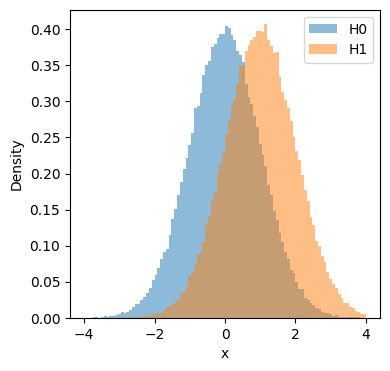

In [4]:
num_train_per_class = 100000
# Generate synthetic training data for two classes
train_H0 = generate_synthetic_data(num_train_per_class, loc=0, scale=1)
train_H0['label'] = 0
train_H1 = generate_synthetic_data(num_train_per_class, loc=1, scale=1)
train_H1['label'] = 1
train_data = pd.concat([train_H0, train_H1]).reset_index(drop=True)

# Plot histograms of the synthetic training data
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_H0['x'], bins=100, range=(-4,4), alpha=0.5, label='H0', density=True)
ax.hist(train_H1['x'], bins=100, range=(-4,4), alpha=0.5, label='H1', density=True)
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.legend(loc='best')
plt.show()

The observed data is stored in `data_simple.csv`. Let's plot the observed data on top of the expected distributions for the two classes.

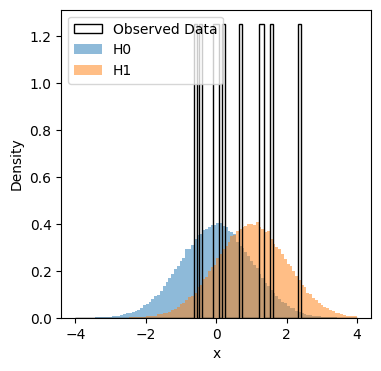

In [5]:
# Load the data from csv file
data_obs = pd.read_csv('data_simple.csv')
N_obs = len(data_obs)

# Plot histogram of the observed data
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(data_obs['x'], bins=100, range=(-4,4), color='black', histtype='step', label='Observed Data', density=True)
ax.hist(train_H0['x'], bins=100, range=(-4,4), alpha=0.5, label='H0', density=True)
ax.hist(train_H1['x'], bins=100, range=(-4,4), alpha=0.5, label='H1', density=True)
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.legend(loc='upper left')
plt.show()

Can you tell by eye which class the observed data belong to? In any case, let's perform a proper hypothesis test. We will start with the analytic solution.

## Analytic likelihood-ratio
<div style="background-color:#0000">

The probability of observation $x_i$ is given by the following formula, assuming $x$ follows a Gaussian distribution with mean $\mu$ and width $\sigma$ is:

$$
p(x_i|\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{(x_i-\mu)^2}{2\sigma^2}}
$$

Therefore, the likelihood over dataset $\mathcal{D} = \{x_i\}$ of $N_{obs}$ samples is:

$$
p(\mathcal{D}|\mu,\sigma) = \prod^{N_{obs}}_{x_i \in \mathcal{D}} p(x_i|\mu,\sigma)
$$

As discussed above, the Neyman-Pearson lemma tells us that the log-likelihood ratio is the most powerful test-statistic for simple hypothesis testing ($\mathcal{H}_0$ vs $\mathcal{H}_1$). We will use $2\Delta\mathrm{NLL}$ as convention for the choice of test-statistic: 

$$
t = 2\Delta\mathrm{NLL} = -2 \ln {\frac{p(\mathcal{D}|\mathcal{H}_1)}{p(\mathcal{D}|\mathcal{H}_0)}}
$$
</div>
Do you know why we use the "twice-negative" as convention? The answer lies in **Wilk's theorem**: the twice-negative log-likelihood ratio asymptotically approaches the $\chi^2$ distribution under the null hypothesis. This means we can use the properties of the $\chi^2$ function to determine the probability distribution of the test-statistic, and subsequently the coverage/confidence intervals. Anyway we will come to this in the parameter estimation section.

Let's code this up...

In [6]:
# Function to calculate log-likelihood ratio between two hypotheses with (mu0, sigma0) vs (mu1, sigma1)
def log_likelihood_ratio(x, mu0=0, mu1=1, sigma0=1, sigma1=1):
    ll_H0 = -0.5 * ((x - mu0) / sigma0)**2 - np.log(sigma0) - 0.5 * np.log(2 * np.pi)
    ll_H1 = -0.5 * ((x - mu1) / sigma1)**2 - np.log(sigma1) - 0.5 * np.log(2 * np.pi)
    return ll_H1 - ll_H0

# Function to calculate test statistic (2NLL) over all events 
def test_statistic(x, mu0=0, mu1=1, sigma0=1, sigma1=1):
    llr = log_likelihood_ratio(x, mu0, mu1, sigma0, sigma1)
    return -2 * np.sum(llr)

To perform a hypothesis test we need to first generate synthetic datasets (toys) which are representative of the observed data ($N_{obs}=10$), under each hypothesis. For each "toy" we will calculate the value of the test statistic, building up a distributions of the test statistic under the two hypotheses.

We then calculate the test-statistic value for the observed data, and compare this to the distributions.

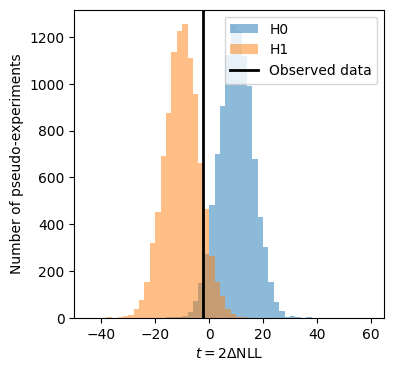

In [7]:
N_toys = 10000
test_statistic_H0 = []
test_statistic_H1 = []
for _ in range(N_toys):
    # Samples under H0
    samples_H0 = generate_synthetic_data(N_obs, loc=0, scale=1, seed=None)
    t_H0 = test_statistic(samples_H0['x'], mu0=0, mu1=1, sigma0=1, sigma1=1)
    test_statistic_H0.append(t_H0)

    # Samples under H1
    samples_H1 = generate_synthetic_data(N_obs, loc=1, scale=1, seed=None)
    t_H1 = test_statistic(samples_H1['x'], mu0=0, mu1=1, sigma0=1, sigma1=1)
    test_statistic_H1.append(t_H1)

# Calculate observed test statistic
t_obs = test_statistic(data_obs['x'], mu0=0, mu1=1, sigma0=1, sigma1=1)

# Plot the distributions of the test statistic under both hypotheses, as well as the observed case
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(test_statistic_H0, bins=50, alpha=0.5, range=(-50,50), label='H0')
ax.hist(test_statistic_H1, bins=50, alpha=0.5, range=(-50,50), label='H1')
ax.axvline(t_obs, color='black', linestyle='solid', linewidth=2, label='Observed data')
ax.set_xlabel('$t = 2\\Delta$NLL')
ax.set_xlim(-50, 65)
ax.set_ylabel('Number of pseudo-experiments')
ax.legend(loc='best')


From the test-statistic distributions we can calculate the $p$-value with respect to the null hypothesis ($\mathcal{H}_0$) by integrating the left-hand tail of the $\mathcal{H}_0$ distribution up to the observed value of the test-statistic. This $p$-value tells us:
* Assuming $\mathcal{H}_0$ is true, what is the probability of obtaining data at least as extreme as what you observed, over a long run of repeated identical experiments.

If the $p$-value is below some pre-defined critical threshold ($\alpha=0.05$), then we can reject the null-hypothesis at the $1-\alpha$ confidence level (CL). 

We can calculate the Type-1 and Type-2 error rate for fixed $\alpha$ and subsequently the power of the test. The error rates are defined as follows:
* Type-1: assuming $\mathcal{H}_0$ is true, it is the probability of incorrectly rejecting $\mathcal{H}_0$ ($=\alpha$) i.e. false positive rate.
* Type-2: assuming $\mathcal{H}_1$ is true, it is the probability of incorrectly failing to reject $\mathcal{H}_0$ ($\beta$) i.e. it quantifies the fraction of the $\mathcal{H}_1$ distribution which lies beyond the critical value. In this way ($1-\beta$) is equal to the true positive rate (which is also referred to as the statistical power). 

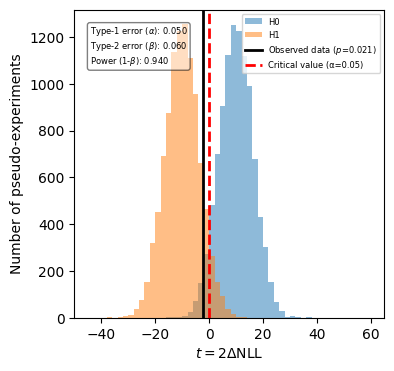

In [8]:
# Calculate the p-value for H0
p_value_H0 = np.sum(np.array(test_statistic_H0) <= t_obs) / N_toys

# Calculate the type-1 and type-2 errors and the statistical power for fixed alpha=0.05
alpha = 0.05
type_1_error = alpha
critical_value = np.percentile(test_statistic_H0, alpha * 100)
type_2_error = np.sum(np.array(test_statistic_H1) > critical_value) / N_toys
power = 1 - type_2_error    

# Plot results again with additional annotations
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(test_statistic_H0, bins=50, alpha=0.5, range=(-50,50), label='H0')
ax.hist(test_statistic_H1, bins=50, alpha=0.5, range=(-50,50), label='H1')
ax.axvline(t_obs, color='black', linestyle='solid', linewidth=2, label='Observed data ($p$={:.3f})'.format(p_value_H0))
ax.axvline(critical_value, color='red', linestyle='dashed', linewidth=2, label='Critical value (α={})'.format(alpha))
ax.set_xlabel('$t = 2\\Delta$NLL')
ax.set_xlim(-50, 65)
ax.set_ylabel('Number of pseudo-experiments')
ax.legend(loc='best', fontsize=6)
# Add text to plot with type-1, type-2 errors and power
textstr = '\n'.join((
    'Type-1 error ($\\alpha$): {:.3f}'.format(type_1_error),
    'Type-2 error ($\\beta$): {:.3f}'.format(type_2_error),
    'Power (1-$\\beta$): {:.3f}'.format(power)))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=6,
        verticalalignment='top', bbox=props)
plt.show()


Our $p$-value is less than the critical value ($\alpha=0.05$). We can reject the null hypothesis $\mathcal{H}_0$ for this data at the 95% CL.

We can also calculate a compatibility $p$-value with respect to the alternative hypothesis $\mathcal{H}_1$. What we want to know is "how extreme is the observed data compared to what I would expect under $\mathcal{H}_1$? Since large values of the test-statistic look more like $\mathcal{H}_0$, then here it is flipped i.e. is it the upper tail of the $\mathcal{H}_1$ distribution which indicates the incompatibility with $\mathcal{H}_1$. 

Let's calculate this quantity:

In [9]:
# Calculate p-value for alternative hypothesis
p_value_H1 = np.sum(np.array(test_statistic_H1) >= t_obs) / N_toys

# Print p-values for both hypotheses
print('P-value for H0: {:.5f}'.format(p_value_H0))
print('P-value for H1: {:.5f}'.format(p_value_H1))

P-value for H0: 0.02150
P-value for H1: 0.11480


The data is much more compatible with the alternative hypothesis! Note this might not always be the case i.e. you may have two hypotheses, neither of which fit the data well. Under this scenario one should look towards forming a different hypothesis.

A ROC curve tells us the trade-off between the Type-I error rate (false positives) and the 1 - Type-II error rate (true positives). We move the threshold ($\alpha$) and calculate $1-\beta$, as shown in the code block below. The area-under-curve (AUC) metric is a measure of how well the test statistic separates the $\mathcal{H}_0$ and $\mathcal{H}_1$ distributions i.e. the power of the test.

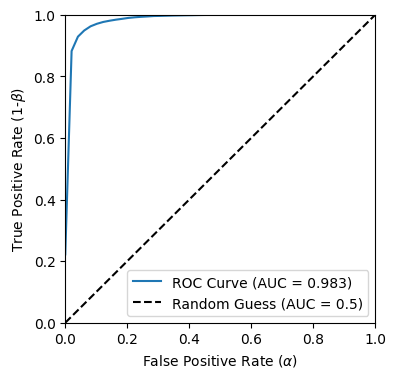

In [10]:
alpha_vals = np.linspace(0.0, 1.0, 50)
beta_vals = []
for alpha in alpha_vals:
    critical_value = np.percentile(test_statistic_H0, alpha * 100)
    type_2_error = np.sum(np.array(test_statistic_H1) > critical_value) / N_toys
    beta_vals.append(type_2_error)

fpr = alpha_vals
tpr = 1 - np.array(beta_vals)

# Calculate AUC using trapezoidal rule
auc = np.trapezoid(tpr, fpr)

# Plot the ROC curve (beta vs alpha)
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(auc))
ax.plot([0, 1], [0, 1], color='black', linestyle='dashed', label='Random Guess (AUC = 0.5)')
ax.set_xlabel('False Positive Rate ($\\alpha$)')
ax.set_ylabel('True Positive Rate (1-$\\beta$)')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend(loc='best')
plt.show()

## Learning the likelihood-ratio

As discussed in [Section 2](#sbi_with_classifiers) we can use a binary classifier to approximate the likelihood ratio. 

In this simple 1D example we will use <u>**logistic regression**</u>. Logistic regression is a simple linear classifer: it passes a linear (weighted) sum of the obvservable(s) through a sigmoid function, to map any number to a probability that the sample belongs to $\mathcal{H}_0$ or $\mathcal{H}_1$. By minimising the loss in training, we find the optimal weights for each observable. More information can be found in [1]. 

Note, the SBI approach extends to more complicated classifier architectures (e.g. BDTs, neural networks), which become useful when dealing with more complex inference problems i.e. higher dimensions, more complicated features.

[1] - Hastie, T. et al, "The Elements of Statistical Learning", Section 4.4 [Link](https://www.sas.upenn.edu/~fdiebold/NoHesitations/BookAdvanced.pdf)

In [11]:
# Train a logistic regression classifier to distinguish between H0 and H1
clf = LogisticRegression(solver='liblinear')
X_train = train_data[['x']].values
y_train = train_data['label'].values.astype(int)
# Fit classifier with BCE loss
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


After the classifier $\hat{f}(x)$ has been trained, we can examine the output. Let's first generate independent simulation samples under the two hypotheses. We can then compare the classifier output score distribution from the simulation, to that of the observed data.

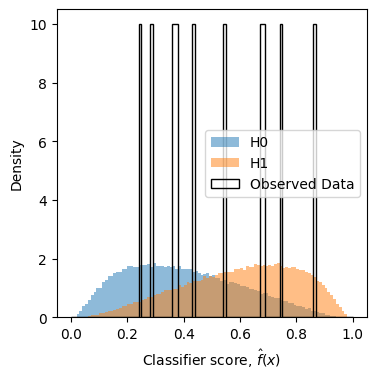

In [12]:
# Evaluate classifier scores on independent test data from the two classes
num_test_per_class = 100000
test_H0 = generate_synthetic_data(num_test_per_class, loc=0, scale=1)
test_H1 = generate_synthetic_data(num_test_per_class, loc=1, scale=1)
scores_H0 = clf.predict_proba(test_H0[['x']].values)[:, 1]
scores_H1 = clf.predict_proba(test_H1[['x']].values)[:, 1]

# Evaluate classifier scores on observed data
scores_obs = clf.predict_proba(data_obs[['x']].values)[:, 1]

# Plot histograms of the classifier scores
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(scores_H0, bins=100, range=(0,1), alpha=0.5, label='H0', density=True)
ax.hist(scores_H1, bins=100, range=(0,1), alpha=0.5, label='H1', density=True)
ax.hist(scores_obs, bins=100, range=(0,1), color='black', histtype='step', label='Observed Data', density=True)
ax.set_xlabel('Classifier score, $\\hat{f}(x)$')
ax.set_ylabel('Density')
ax.legend(loc='best')
plt.show()

Does the observed classifier score distribution help identify the correct hypothesis? Let's do the full test...

<div style="background-color:#0000">

Using the likelihood-ratio trick, the classifier output can be converted to the density ratio:

$$
\frac{\hat{f}(x_i)}{1-\hat{f}(x_i)} \approx \frac{p(x_i|\mathcal{H}_1)}{p(x_i|\mathcal{H}_0)}
$$

With this, we can approximate the test-statistic over the full ($N_{obs}=10$) dataset ($\mathcal{D}$):

$$
t \approx -2  \sum^{N_{obs}}_{x_i \in \mathcal{D}} \ln{\bigg(\frac{\hat{f}(x_i)}{1-\hat{f}(x_i)}\bigg)}
$$

</div>

In the same way as the analytic approach, we will write python functions to calculate the log-likelihood ratio and the test-statistic. These functions evaluate the classifier on input data $\{x_i\} \in \mathcal{D}$, convert the classifier output to the log-likelihood-ratio per sample, and then calculate the test-statistic over the dataset by summing the values and multiplying by -2. Note, we clip the classifier output scores to avoid log(0) in the calculation.

In [14]:
def log_likelihood_ratio_clf(x, clf, clip=1e-10):
    scores = clf.predict_proba(x.reshape(-1, 1))[:, 1]
    # Avoid log(0) by clipping scores
    scores = np.clip(scores, clip, 1-clip)
    llr = np.log(scores / (1 - scores))
    return llr

def test_statistic_clf(x, clf):
    llr = log_likelihood_ratio_clf(x, clf)
    return -2 * np.sum(llr)

With this we can perform the same hypothesis-testing procedure but now using the learned test-statistic. Let's generate toy datasets under each hypothesis with $N_{obs}=10$. For each toy we will calculate the analytic and learned test-statistic values, building up distributions of each under the two hypotheses. We can then calculate the analytic and learned test-statistic values for the observed dataset, and calculate the $p$-values with respect to the null hypothesis.

We will also compare the statistical power of each hypothesis test.

In [15]:
N_toys = 10000
test_statistic_H0_clf = []
test_statistic_H1_clf = []
test_statistic_H0_analytic = []
test_statistic_H1_analytic = []
for _ in range(N_toys):
    # Samples under H0
    samples_H0 = generate_synthetic_data(N_obs, loc=0, scale=1, seed=None)
    t_H0_clf = test_statistic_clf(samples_H0['x'].values, clf)
    t_H0_analytic = test_statistic(samples_H0['x'], mu0=0, mu1=1, sigma0=1, sigma1=1)
    test_statistic_H0_clf.append(t_H0_clf)
    test_statistic_H0_analytic.append(t_H0_analytic)

    # Samples under H1
    samples_H1 = generate_synthetic_data(N_obs, loc=1, scale=1, seed=None)
    t_H1_clf = test_statistic_clf(samples_H1['x'].values, clf)
    t_H1_analytic = test_statistic(samples_H1['x'], mu0=0, mu1=1, sigma0=1, sigma1=1)
    test_statistic_H1_clf.append(t_H1_clf)
    test_statistic_H1_analytic.append(t_H1_analytic)

# Calculate observed test statistic
t_obs_clf = test_statistic_clf(data_obs['x'].values, clf)
t_obs_analytic = test_statistic(data_obs['x'], mu0=0, mu1=1, sigma0=1, sigma1=1)

In [16]:
# Calculate the p-values for H0
p_value_H0_clf = np.sum(np.array(test_statistic_H0_clf) <= t_obs_clf) / N_toys
p_value_H0_analytic = np.sum(np.array(test_statistic_H0_analytic) <= t_obs_analytic) / N_toys

# Calculate the type-1 and type-2 errors for fixed alpha=0.05
alpha = 0.05
type_1_error = alpha
critical_value_clf = np.percentile(test_statistic_H0_clf, alpha * 100)
critical_value_analytic = np.percentile(test_statistic_H0_analytic, alpha * 100)
type_2_error_clf = np.sum(np.array(test_statistic_H1_clf) > critical_value_clf) / N_toys
type_2_error_analytic = np.sum(np.array(test_statistic_H1_analytic) > critical_value_analytic) / N_toys
power_clf = 1 - type_2_error_clf
power_analytic = 1 - type_2_error_analytic

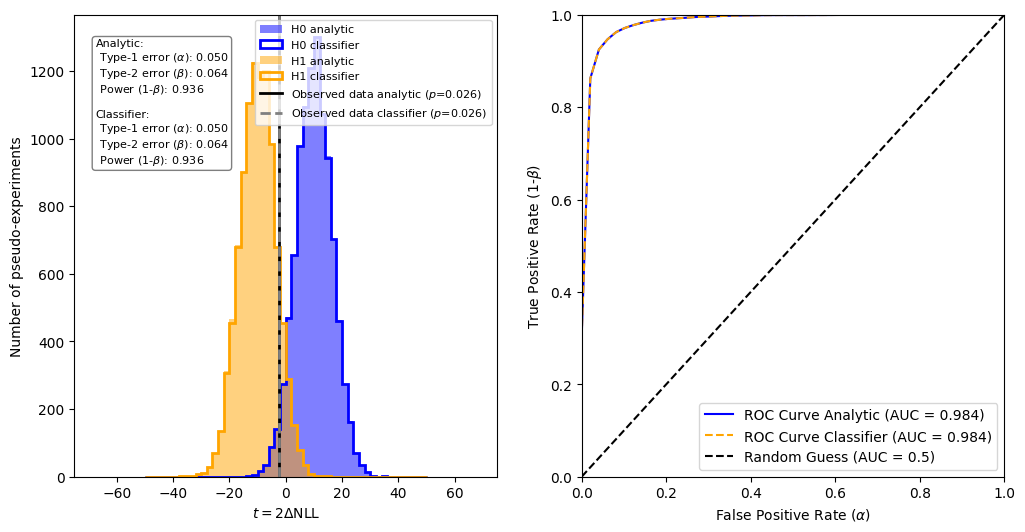

In [17]:
# Plot results: compare analytic vs classifier-based test statistics
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].hist(test_statistic_H0_analytic, bins=50, alpha=0.5, range=(-50,50), label='H0 analytic', color='blue')
ax[0].hist(test_statistic_H0_clf, bins=50, range=(-50,50), label='H0 classifier', color='blue', histtype='step', linewidth=2)
ax[0].hist(test_statistic_H1_analytic, bins=50, alpha=0.5, range=(-50,50), label='H1 analytic', color='orange')
ax[0].hist(test_statistic_H1_clf, bins=50, range=(-50,50), label='H1 classifier', color='orange', histtype='step', linewidth=2)
ax[0].axvline(t_obs_analytic, color='black', linestyle='solid', linewidth=2, label='Observed data analytic ($p$={:.3f})'.format(p_value_H0_analytic))
ax[0].axvline(t_obs_clf, color='grey', linestyle='dashed', linewidth=2, label='Observed data classifier ($p$={:.3f})'.format(p_value_H0_clf))

ax[0].set_xlabel('$t = 2\\Delta$NLL')
ax[0].set_xlim(-75, 75)
ax[0].set_ylabel('Number of pseudo-experiments')
ax[0].legend(loc='upper right', fontsize=8)

# Add text to plot with type-1, type-2 errors and power for both methods
textstr = '\n'.join((
    'Analytic:',
    ' Type-1 error ($\\alpha$): {:.3f}'.format(type_1_error),
    ' Type-2 error ($\\beta$): {:.3f}'.format(type_2_error_analytic),
    ' Power (1-$\\beta$): {:.3f}'.format(power_analytic),
    '',
    'Classifier:',
    ' Type-1 error ($\\alpha$): {:.3f}'.format(type_1_error),
    ' Type-2 error ($\\beta$): {:.3f}'.format(type_2_error_clf),
    ' Power (1-$\\beta$): {:.3f}'.format(power_clf)))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax[0].text(0.05, 0.95, textstr, transform=ax[0].transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

# Plot ROC curves for both methods
alpha_vals = np.linspace(0.0, 1.0, 50)
beta_vals_analytic = []
beta_vals_clf = []
for alpha in alpha_vals:
    critical_value_analytic = np.percentile(test_statistic_H0_analytic, alpha * 100)
    type_2_error_analytic = np.sum(np.array(test_statistic_H1_analytic) > critical_value_analytic) / N_toys
    beta_vals_analytic.append(type_2_error_analytic)

    critical_value_clf = np.percentile(test_statistic_H0_clf, alpha * 100)
    type_2_error_clf = np.sum(np.array(test_statistic_H1_clf) > critical_value_clf) / N_toys
    beta_vals_clf.append(type_2_error_clf)

fpr = alpha_vals
tpr_analytic = 1 - np.array(beta_vals_analytic)
tpr_clf = 1 - np.array(beta_vals_clf)

# Calculate AUC using trapezoidal rule
auc_analytic = np.trapezoid(tpr_analytic, fpr)
auc_clf = np.trapezoid(tpr_clf, fpr)

# Plot the ROC curve (beta vs alpha) for both methods
ax[1].plot(fpr, tpr_analytic, label='ROC Curve Analytic (AUC = {:.3f})'.format(auc_analytic), color='blue')
ax[1].plot(fpr, tpr_clf, label='ROC Curve Classifier (AUC = {:.3f})'.format(auc_clf), color='orange', linestyle='dashed')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='dashed', label='Random Guess (AUC = 0.5)')
ax[1].set_xlabel('False Positive Rate ($\\alpha$)')
ax[1].set_ylabel('True Positive Rate (1-$\\beta$)')
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1)
ax[1].legend(loc='best')
plt.show()



## Summary
We have "learned" a test-statistic which is essentially identical to the analytic solution. Instead, this was derived using a simple logistic regression binary classifier. We have shown how to use the output of this classifier to perform a full hypothesis tests. The observed data is inconsistent with the null hypothesis ($\mathcal{H}_0$), with a $p$-value of less than 0.05. Therefore, under the two-class scenario, we conclude that the observed data support the $\mathcal{H}_1$ hypothesis. 

In this simple 1D Gaussian example, we were able to use the analytic solution as a point of comparison. For most real-world scenarios, we do not have the analytic likelihood. In the next section, we will explore an example in which the analytic likelihood is not known.

<hr style="border:2px solid gray">

# 4. Hypothesis test in higher-dimensions (particle spin example) <a id='complex_hypothesis_test'></a>

Let's use what we have learned in the previous section to perform a hypothesis test when the analytic likelihood is not known. 

This example concerns the measurement of particle's spin; a purely quantum mechanical property of an elementary particle. It is an intrinsic form of angular momentum, but unlike everyday spinning objects, it does not correspond to any literal rotation in space. Instead, it influences how particles behave, decay, and interact with forces, making it possible to distinguish different types of particles by their spin values.

We are going to study the spin of a hypothetical particle $X$, by performing an experiment to look at how it decays.

### Aim: 

Infer the spin-configuration of a particle $X$. 

### Dataset: 

Three observables ($x_1$, $x_2$, $x_3$) related to the decay products of $X \rightarrow aa$. The observed dataset contains $N_{obs}=10$ particle $X$ decays, and is stored in the file `data_spin.csv`.

### Hypotheses: 
* $\mathcal{H}_0$ = Spin-0 particle
* $\mathcal{H}_1$ = Spin-1 particle

### Simulation: 

We have a faithful particle decay simulator which can reproduce the observable distributions of $X \rightarrow aa$ under each hypothesis. The simulator can generate $N$ decays using the following code:
```python
sim_H0 = run_simulation(N, hypothesis='H0')
sim_H1 = run_simulation(N, hypothesis='H1')
```

### Tasks: 
1. Data exploration to understand the problem
1. Train a binary classifier to distinguish decays generated under $\mathcal{H}_0$ from those under $\mathcal{H}_1$
1. Use the classifier output to perform a hypothesis test on the observed data and infer the spin-configuration of particle $X$.


## Data exploration

We will begin by generating synthetic data (simulation) and looking at the expected observable distributions under the two hypotheses. Now the simulator is a "black-box"... all we know is that it produces faithful synthetic data under the two hypotheses.

In [18]:
from sbi_utils import run_simulation
N_train = 100000
sim_H0 = run_simulation(N_train, hypothesis='H0')
sim_H1 = run_simulation(N_train, hypothesis='H1')

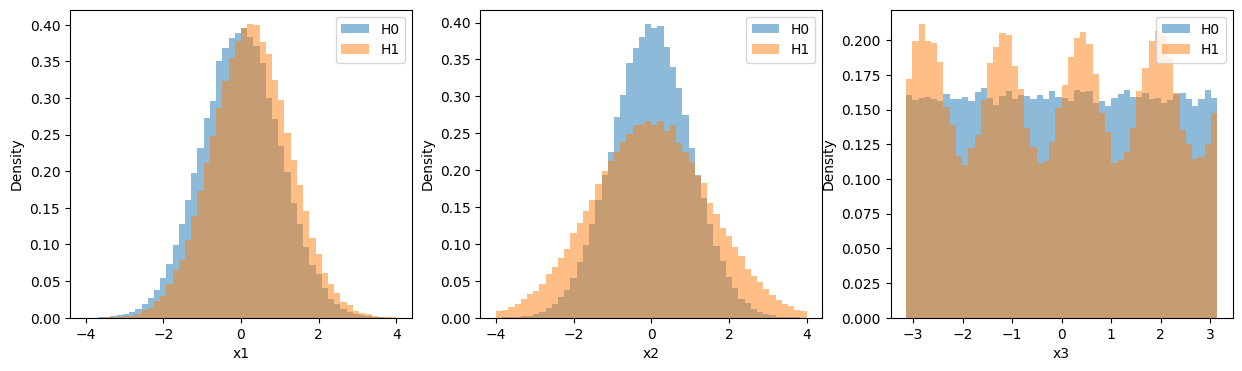

In [19]:
# Plot observable distributions of synthetic data for each hypothesis
fig, axs = plt.subplots(1, 3, figsize=(15,4)) 
axs[0].hist(sim_H0['x1'], bins=50, range=(-4,4), alpha=0.5, label='H0', density=True)
axs[0].hist(sim_H1['x1'], bins=50, range=(-4,4), alpha=0.5, label='H1', density=True)
axs[0].set_xlabel('x1')
axs[0].set_ylabel('Density')
axs[0].legend(loc='best')

axs[1].hist(sim_H0['x2'], bins=50, range=(-4,4), alpha=0.5, label='H0', density=True)
axs[1].hist(sim_H1['x2'], bins=50, range=(-4,4), alpha=0.5, label='H1', density=True)
axs[1].set_xlabel('x2')
axs[1].set_ylabel('Density')
axs[1].legend(loc='best')

axs[2].hist(sim_H0['x3'], bins=50, range=(-np.pi,np.pi), alpha=0.5, label='H0', density=True)
axs[2].hist(sim_H1['x3'], bins=50, range=(-np.pi,np.pi), alpha=0.5, label='H1', density=True)
axs[2].set_xlabel('x3')
axs[2].set_ylabel('Density')
axs[2].legend(loc='best')

plt.show()

We see that $(x1,x2)$ appear to be Gaussian distributed, where $x_1$ differs in mean between $\mathcal{H}_0$ and $\mathcal{H}_1$, while $x_2$ differs in the width. The third observable $x_3$ follows a sinusoidal-like distribution for $\mathcal{H}_1$, and is uniform for $\mathcal{H}_0$.

We can also look at 2D pairs of observables...

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))
axs[0][0].hist2d(sim_H0['x1'], sim_H0['x2'], bins=50, range=[[-4,4],[-4,4]], density=True, cmap='Blues')
axs[0][0].set_xlabel('x1')
axs[0][0].set_ylabel('x2')
axs[0][0].set_title('H0')
axs[1][0].hist2d(sim_H1['x1'], sim_H1['x2'], bins=50, range=[[-4,4],[-4,4]], density=True, cmap='Oranges')
axs[1][0].set_xlabel('x1')
axs[1][0].set_ylabel('x2')
axs[1][0].set_title('H1')
axs[0][1].hist2d(sim_H0['x1'], sim_H0['x3'], bins=50, range=[[-4,4],[-np.pi,np.pi]], density=True, cmap='Blues')
axs[0][1].set_xlabel('x1')
axs[0][1].set_ylabel('x3')
axs[0][0].set_title('H0')
axs[1][1].hist2d(sim_H1['x1'], sim_H1['x3'], bins=50, range=[[-4,4],[-np.pi,np.pi]], density=True, cmap='Oranges')
axs[1][1].set_xlabel('x1')
axs[1][1].set_ylabel('x3')
axs[1][0].set_title('H1')
axs[0][2].hist2d(sim_H0['x2'], sim_H0['x3'], bins=50, range=[[-4,4],[-np.pi,np.pi]], density=True, cmap='Blues')
axs[0][2].set_xlabel('x2')
axs[0][2].set_ylabel('x3')
axs[0][0].set_title('H0')
axs[1][2].hist2d(sim_H1['x2'], sim_H1['x3'], bins=50, range=[[-4,4],[-np.pi,np.pi]], density=True, cmap='Oranges')
axs[1][2].set_xlabel('x2')
axs[1][2].set_ylabel('x3')
axs[1][0].set_title('H1')
plt.show()

The first two observables $x_1$ and $x_1$ have a different correlation structure for the two hypotheses:
* $\mathcal{H}_0$ (spin 0) = positive correlation
* $\mathcal{H}_1$ (spin 1) = uncorrelated

The classifier will be able to leverage this higher-dimensional information (correlation between features) to better discriminate between $\mathcal{H}_0$ and $\mathcal{H}_1$. Better discrimination leads to an improvement in the statistical power of the test.

Let's look at how the observed dataset is distributed...

In [20]:
# Load data
data_obs = pd.read_csv('data_spin.csv')
N_obs = len(data_obs)

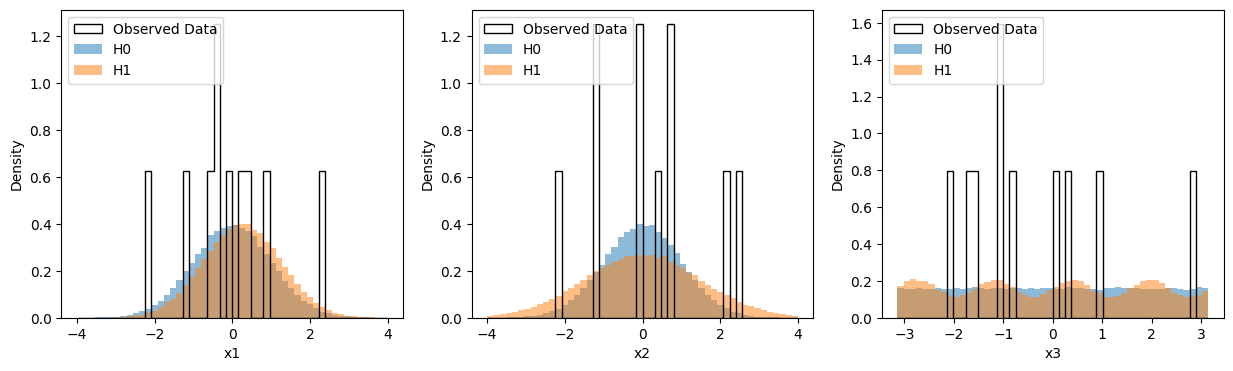

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].hist(data_obs['x1'], bins=50, range=(-4,4), color='black', histtype='step', label='Observed Data', density=True)
ax[0].hist(sim_H0['x1'], bins=50, range=(-4,4), alpha=0.5, label='H0', density=True)
ax[0].hist(sim_H1['x1'], bins=50, range=(-4,4), alpha=0.5, label='H1', density=True)
ax[0].set_xlabel('x1')
ax[0].set_ylabel('Density')
ax[0].legend(loc='upper left')

ax[1].hist(data_obs['x2'], bins=50, range=(-4,4), color='black', histtype='step', label='Observed Data', density=True)
ax[1].hist(sim_H0['x2'], bins=50, range=(-4,4), alpha=0.5, label='H0', density=True)
ax[1].hist(sim_H1['x2'], bins=50, range=(-4,4), alpha=0.5, label='H1', density=True)
ax[1].set_xlabel('x2')
ax[1].set_ylabel('Density')
ax[1].legend(loc='upper left')

ax[2].hist(data_obs['x3'], bins=50, range=(-np.pi,np.pi), color='black', histtype='step', label='Observed Data', density=True)
ax[2].hist(sim_H0['x3'], bins=50, range=(-np.pi,np.pi), alpha=0.5, label='H0', density=True)
ax[2].hist(sim_H1['x3'], bins=50, range=(-np.pi,np.pi), alpha=0.5, label='H1', density=True)
ax[2].set_xlabel('x3')
ax[2].set_ylabel('Density')
ax[2].legend(loc='upper left')

plt.show()

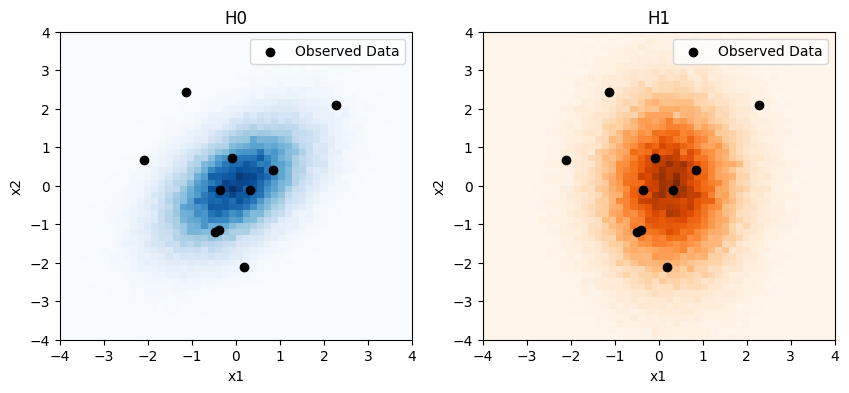

In [22]:
# 2D histogram in (x1,x2): observed data overlaid as scatter points on top of density plots
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].hist2d(sim_H0['x1'], sim_H0['x2'], bins=50, range=[[-4,4],[-4,4]], density=True, cmap='Blues')
axs[0].scatter(data_obs['x1'], data_obs['x2'], color='black', label='Observed Data')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[0].set_title('H0')
axs[0].legend()

axs[1].hist2d(sim_H1['x1'], sim_H1['x2'], bins=50, range=[[-4,4],[-4,4]], density=True, cmap='Oranges')
axs[1].scatter(data_obs['x1'], data_obs['x2'], color='black', label='Observed Data')
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')
axs[1].set_title('H1')
axs[1].legend()

plt.show()

Can you tell by eye which class the observed data belong to? Now it is not so simple!

Let's train a classifier and set up a proper hypothesis test as in [Section 3](#simple_hypothesis_test).

## Train a classifier
In the 1D Gaussian example, we used a simple logistic regression for the classification task. This may not be sufficient when we extend to more complicated inference tasks. In this 3D example, we will now use a neural network to classify $\mathcal{H}_0$ vs $\mathcal{H}_1$. This will be a simple multi-layer perceptron (MLP), which will be trained using the simulated datasets. We will use the `torch` library to build the MLP.

It is important to note that this approach to SBI does not depend on the architecture of the classifier. You can use whichever ML model is most appropriate to the problem (e.g. BDT, CNN, GNN etc). All the method requires is training with a BCE loss function. 

In [23]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Function to convert pandas dataframe to a torch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [24]:
# Build training dataset 
sim_H0['label'] = 0
sim_H1['label'] = 1
sim = pd.concat([sim_H0, sim_H1], ignore_index=True)

# Split into test/train sets
test_size = 0.2
sim_train, sim_test = train_test_split(sim, test_size=test_size, shuffle=True)

# Convert to torch tensors
X_train = df_to_tensor(sim_train[['x1', 'x2', 'x3']])
y_train = df_to_tensor(sim_train[['label']])
X_test = df_to_tensor(sim_test[['x1', 'x2', 'x3']])
y_test = df_to_tensor(sim_test[['label']])

# Create DataLoader for batching
batch_size = 2048
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [25]:
# Define simple feedforward MLP with two hidden layers: input -> hidden -> hidden -> output (1)
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out))
        return out

# Initialize model, loss function and optimizer
input_size = 3
hidden_size = 16
model = SimpleMLP(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [27]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU count: {torch.cuda.device_count()}")

CUDA available: True
CUDA version: 12.6
PyTorch version: 2.9.1+cu126
GPU device: NVIDIA GeForce RTX 3070
GPU count: 1


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = model.to(device)

# Training loop: track loss per epoch for training and esting datasets
num_epochs = 50
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move to device

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move to device

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)
    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

Using device: cuda


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

Let's first look at the training history to see if we have reached the plateau...

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
ax.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

Looks reasonable!

Now let's take a look at the classifier output. We will plot the distribution of $f(x)$ for $\mathcal{H}_0$ and $\mathcal{H}_1$ from the test dataset, and compare this to the classifier output distribution for the observed data. 

Does this help indicate which hypothesis the data belong to?

In [ ]:
# Evaluate the trained model on the test simulation samples
model.eval()
with torch.no_grad():
    sim_test_outputs = model(X_test).numpy().flatten()
sim_test_labels = y_test.numpy().flatten()

# Also evaluate for the observed data
X_obs = df_to_tensor(data_obs[['x1', 'x2', 'x3']])
with torch.no_grad():
    obs_outputs = model(X_obs).numpy().flatten()

# Plot histograms of the classifier scores
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(sim_test_outputs[sim_test_labels==0], bins=100, range=(0,1), alpha=0.5, label='H0', density=True)
ax.hist(sim_test_outputs[sim_test_labels==1], bins=100, range=(0,1), alpha=0.5, label='H1', density=True)
ax.hist(obs_outputs, bins=100, range=(0,1), color='black', histtype='step', label='Observed Data', density=True)
ax.set_xlabel('Classifier score, $\\hat{f}(\\mathbf{x})$')
ax.set_ylabel('Density')
ax.legend(loc='best')
plt.show()

## Hypothesis testing
Following the same procedure as in [Section 3](#simple_hypothesis_test), we will now use the classifier output to perform a hypothesis test. 

<div style="background-color:#0000">

In exactly the same way, we can convert the classifier output to the density ratio using the likelihood-ratio trick:

$$
\frac{\hat{f}(x_i)}{1-\hat{f}(x_i)} \approx \frac{p(x_i|\mathcal{H}_1)}{p(x_i|\mathcal{H}_0)}
$$

And with this, we can approximate the test-statistic over the full ($N_{obs}=10$) dataset:

$$
t = 2\Delta\mathrm{NLL} = -2 \ln{\frac{p(\mathcal{D}|\mathcal{H}_1)}{p(\mathcal{D}|\mathcal{H}_0)}} \approx -2  \sum^{N_{obs}}_{x_i \in \mathcal{D}} \ln{\bigg(\frac{\hat{f}(x_i)}{1-\hat{f}(x_i)}\bigg)}
$$

</div>

Let's rewrite the python functions to be compatible with the torch-based model:

In [27]:
def log_likelihood_ratio_torch(X, model, clip=1e-10):
    with torch.no_grad():
        scores = model(torch.tensor(X, dtype=torch.float32)).numpy().flatten()
    # Avoid log(0) by clipping scores
    scores = np.clip(scores, clip, 1-clip)
    llr = np.log(scores / (1 - scores))
    return llr

def test_statistic_torch(X, model):
    llr = log_likelihood_ratio_torch(X, model)
    return -2 * np.sum(llr)

To perform the hypothesis test we first need to generate toy datasets under each hypothesis with $N_{obs}=10$. We will build up distributions of the learned test-statistic for each hypothesis. We then calculate the test-statistic value for the observed dataset, and determine the $p$-value with respect to the null hypothesis.

In [28]:
N_toys = 10000
test_statistic_H0_clf = []
test_statistic_H1_clf = []
for _ in range(N_toys):
    # Samples under H0
    samples_H0 = run_simulation(N_obs, hypothesis='H0')
    t_H0_clf = test_statistic_torch(samples_H0[['x1', 'x2', 'x3']].values, model)
    test_statistic_H0_clf.append(t_H0_clf)

    # Samples under H1
    samples_H1 = run_simulation(N_obs, hypothesis='H1')
    t_H1_clf = test_statistic_torch(samples_H1[['x1', 'x2', 'x3']].values, model)
    test_statistic_H1_clf.append(t_H1_clf)

# Calculate observed test statistic
t_obs_clf = test_statistic_torch(data_obs[['x1', 'x2', 'x3']].values, model)

# Calculate the p-value for H0
p_value_H0_clf = np.sum(np.array(test_statistic_H0_clf) <= t_obs_clf) / N_toys

Following this we will calculate the Type-I and Type-II errors, as well as the power of the statistical test for fixed $\alpha=0.05$. We will also compute the errors for different $\alpha$ values to construct the ROC curve.

In [ ]:
# Calculate the type-1 and type-2 errors for fixed alpha=0.05
alpha = 0.05
type_1_error = alpha
critical_value_clf = np.percentile(test_statistic_H0_clf, alpha * 100)
type_2_error_clf = np.sum(np.array(test_statistic_H1_clf) > critical_value_clf) / N_toys
power_clf = 1 - type_2_error_clf

# Plot the distributions of the test statistic under both hypotheses, as well as the observed case
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].hist(test_statistic_H0_clf, bins=50, alpha=0.5, range=(-50,50), label='H0')
axs[0].hist(test_statistic_H1_clf, bins=50, alpha=0.5, range=(-50,50), label='H1')
axs[0].axvline(t_obs_clf, color='black', linestyle='solid', linewidth=2, label='Observed data ($p$={:.3f})'.format(p_value_H0_clf))
axs[0].axvline(critical_value_clf, color='red', linestyle='dashed', linewidth=2, label='Critical value (α={})'.format(alpha))
axs[0].set_xlabel('$t = 2\\Delta$NLL')
axs[0].set_xlim(-50, 50)
axs[0].set_ylabel('Number of pseudo-experiments')
axs[0].legend(loc='upper right', fontsize=8)
# Add text to plot with type-1, type-2 errors and power
textstr = '\n'.join((
    'Type-1 error ($\\alpha$): {:.3f}'.format(type_1_error),
    'Type-2 error ($\\beta$): {:.3f}'.format(type_2_error_clf),
    'Power (1-$\\beta$): {:.3f}'.format(power_clf)))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
axs[0].text(0.05, 0.95, textstr, transform=axs[0].transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

# Plot ROC curve
alpha_vals = np.linspace(0.0, 1.0, 1000)
beta_vals_clf = []
for alpha in alpha_vals:
    critical_value_clf = np.percentile(test_statistic_H0_clf, alpha * 100)
    type_2_error_clf = np.sum(np.array(test_statistic_H1_clf) > critical_value_clf) / N_toys
    beta_vals_clf.append(type_2_error_clf)
fpr = alpha_vals
tpr_clf = 1 - np.array(beta_vals_clf)
# Calculate AUC using trapezoidal rule
auc_clf = np.trapezoid(tpr_clf, fpr)
axs[1].plot(fpr, tpr_clf, label='ROC Curve Classifier (AUC = {:.3f})'.format(auc_clf), color='orange')
axs[1].plot([0, 1], [0, 1], color='black', linestyle='dashed', label='Random Guess (AUC = 0.5)')
axs[1].set_xlabel('False Positive Rate ($\\alpha$)')
axs[1].set_ylabel('True Positive Rate (1-$\\beta$)')
axs[1].legend(loc='best')
axs[1].set_xlim(0,1)
axs[1].set_ylim(0,1)
plt.show()



## Summary

We were presented with a research problem with an unknown (intractable) likelihood i.e. we do not know the probability of observing data sample $(x_1,x_2,x_3)$ under hypothesis $\mathcal{H}_i$: $p(x_1,x_2,x_3|\mathcal{H}_i)$.

Nevertheless, we had access to an accurate simulation of the data. We used this simulation to train a classifier to distinguish $\mathcal{H}_0$ (spin-0 particle) from $\mathcal{H}_1$ (spin-1 particle).

The output of the classifier was used to approximate the probability density ratio. This was then used to calculate the log-likelihood-ratio test-statistic over the full dataset. Using a frequentist approach, we compared the observed value of the "learned" test-statistic to the distributions generated from toy experiments under each hypothesis. 

The data is inconsistent with the null hypothesis ($\mathcal{H}_0$) with a $p$-value of less than 0.05. Therefore we can reject $\mathcal{H}_0$ and infer that particle $X$ is spin-one!

This is an end-to-end example of using ML to perform SBI. In the next section we will go beyond hypothesis testing, and show how to use ML classifiers for parameter estimation.

<div style="background-color:#0000">

## Exercises

### 4.1 Amortized inference
One great advantage of this approach is that we can use the trained classifier to perform inference on different observations, assuming that the experiment is performed under identical conditions. This means we do not need to re-run an expensive inference procedure each time. In other words, we have **amortized** the inference for future experiments. This becomes extremely useful when dealing with problems with extremely complex likelihoods.

We re-run the experiment, where $X \rightarrow aa$ decays are recorded over a longer period such that we obtain a larger dataset. This dataset can be found in `data_spin_extension.csv`. Your task is to repeat the hypothesis-test procedure using the larger dataset with the trained classifier. How do your conclusions change? Is this in line with what you expect from taking more data?

</div>

In [ ]:
# YOUR CODE HERE

<div style="background-color:#C2F5DD">

### 4.2 Power of the statistical test
Above we evaluated the statistical power of the test statistic. Using `data_spin.csv` investigate how the power diminishes when you remove the $x_1$ observable. Compare the ROC curves obtained with the 3D and 2D inputs? What does this tell us about the impact of adding more information on the ability to resolve the two hypotheses?

</div>

In [ ]:
sim_reduced = sim[['x2', 'x3']]  # Use only x1 and x2 features
input_size = 2
# YOUR CODE HERE

<hr style="border:2px solid gray">

# 5. Parameter estimation with parametric classifiers <a id='parameter_estimation'></a>

This section will describe how to perform parameter estimation (with the extraction of confidence intervals) using SBI. Note, this is essentially an extension of the hypothesis testing procedure where the alternative hypothesis $\mathcal{H}_1$ is a "composite" hypothesis, containing the ensemble of all possible values for the parameter of interest. As discussed in the introduction, for parameter estimation we need to learn the conditional probability density: $p(x|\theta)$.
This quantity tells us the probabilty of observing data $x$ given parameter value $\theta$. In fact, what we want to learn for inference with classifiers is the conditional density ratio:

$$
\frac{p(x|\theta)}{p(x|\theta_0)}
$$

where $\theta_0$ is some reference value of the parameter. We can then define a log-likelihood-ratio test-statistic to infer $\theta$ from the data, and its corresponding confidence intervals. All we need is a faithful simulator that can generate $x$ for any value of $\theta$.

The parameter estimation with SBI discussed in this notebook is founded on the concept of parametric classifiers [1]. These models are trained such that the classifier output is "parametric" in $\theta$: $\hat{f}(x|\theta)$ i.e. the decision function depends on the value of $\theta$. 

In practice, we learn this by simply adding $\theta$ as an additional parameter to the model training:

![parametric neural network](pnn.png)

Crucially, one must initially make the distribution of the conditional feature ($\theta$) the same between the two classes. 

Let's go through the training steps in detail...

1) Class 0: generate $N$ samples using the simulator for the reference hypothesis $\theta = \theta_0$ i.e. draw samples from $p(x|\theta_0)$ for fixed $\theta_0$. It is up to you what to choose for $\theta_0$ i.e. we must pick a choice for the reference hypothesis. In theory, the final parameter estimation will be independent of this choice, but it helps to pick something sensible which is not too far from the observed parameter values.

2) Class 1: generate $N$ samples using the simulator with different values of $\theta$ i.e. draw samples from $p(x|\theta)$ for various $\theta$. If possible, one should generate the samples to be continuous in the values of $\theta$ i.e. randomly sampled between some upper and lower ranges, where the ranges are chosen to be sufficiently wide for the confidence interval level that you want to probe. In practice it is often much easier to generate subsamples with discrete steps in $\theta$. The method still works as long as the discrete steps are sufficiently fine-grained (compared to the sensitivity). We will use the latter approach in this notebook.

<div style="background-color:#FFCCCB">

3) Consider training a classifier $\hat{f}(x,\theta)$ to distinguish between Class 0 and Class 1 with $\{x,\theta\}$ as input features. After the likelihood-ratio trick, we arrive at an approximation of the joint-likelihood ratio between the two classes:
    $$
    \frac{\hat{f}(x_i,\theta)}{1-\hat{f}(x_i,\theta)} \approx \frac{p(x_i,\theta|\mathrm{Class\,1})}{p(x_i,\theta|\mathrm{Class\,0})}
    $$
    If we expand the joint distributions we obtain:
    $$
    \frac{p(x_i,\theta|\mathrm{Class\,1})}{p(x_i,\theta|\mathrm{Class\,0})} = \frac{p(x_i|\theta)p(\theta|\mathrm{Class\,1})}{p(x_i|\theta_0)p(\theta|\mathrm{Class\,0})}
    $$
    What we want is only the conditional density ratio:
    $$
    \frac{p(x_i|\theta)}{p(x_i|\theta_0)}
    $$
    Hence, we need to make sure the conditional parameter distributions are the same between the two classes:
    $$
    p(\theta|\mathrm{Class\,1}) = p(\theta|\mathrm{Class\,0})
    $$
    so that the terms cancel in the joint density ratio, and we are left with just the conditional density ratio. 
    
    In other words, we need the $\theta$ parameter distributions in Class 0 and Class 1 to have identical densities. In practice, this means using the same sampling distribution for $\theta$ in both classes. If they differ, the classifier will pick up class-specific information about how often certain $\theta$ values appear in each class, rather than purely how likely the data $x$ are given $\theta$. This would break the interpretation of the classifier output as a conditional density ratio.

    So before training we need to artificially generate a $\theta$ distribution for Class 0 by sampling from the Class 1 distribution. 

</div> 

4) After the $\theta$ distributions between the two classes are made to be the same in training, the classifier output can be used to approximate the conditional density ratio. We will show later on how this can be used for parameter estimation.

[1] - P. Baldi et al., *Parameterized neural networks for high-energy physics*, Eur. Phys. J. C 76 (2016) 235. [arXiv:1601.07913](https://www.arxiv.org/abs/1601.07913)

## 2D Gaussian example

In this notebook we will follow a simple example, where the analytic likelihood is known. The example is described below:

### Dataset:

Two observables ($x_1, x_2$) which follow a 2D Gaussian distribution. The mean and width related to $x_1$, $\mu_1$ and $\sigma_1$, are known. Only the width related to $x_2$, $\sigma_2$, is known. The two unknowns are $\mu_2$ and the correlation between the observables $\rho_{12}$. We are provided with a dataset of $N_{obs}=20$ samples of ($x_1, x_2$) values stored in `data_parameter_estimation.csv`. 

### Aim:

Infer the values of $\mu_2$ and $\rho_{12}$ from the data, along with the corresponding confidence intervals. Comparing to the notation above $x = \{x_1,x_2\}$ and $\theta = \{\mu_2,\rho_{12}\}$.

### Simulation 

We have a simulator that can generate samples from a 2D Gaussian with arbitrary $\mu_1$, $\sigma_1$, $\mu_2$, $\sigma_2$, $\rho_{12}$. The simulation can generate $N$ samples using the following code:
```python
sim = run_simulation(N, mu1, sigma1, mu2, sigma2, rho12)
```

### Analytic solution

<div style="background-color:#FFCCCB">

The analytic (conditional) probability density for a 2D Gaussian is:

$$
p(x_1,x_2|\mu_1,\sigma_1,\mu_2,\sigma_2,\rho_{12})
=
\frac{1}{2\pi\,\sigma_1\sigma_2\sqrt{1-\rho_{12}^2}}
\exp\!\left(
-\frac{1}{2(1-\rho_{12}^2)}
\left[
\frac{(x_1-\mu_1)^2}{\sigma_1^2}
+
\frac{(x_2-\mu_2)^2}{\sigma_2^2}
-
\frac{2\rho_{12}(x_1-\mu_1)(x_2-\mu_2)}{\sigma_1\sigma_2}
\right]
\right).
$$

We will use this to compare to the "learned" conditional density ratio.

</div>

### Tasks

1. Run the simulation and compare to the observed data
1. Extract analytic result
1. Train a parametric classifier
1. Use parametric classifier output to estimate the values and confidence intervals of $\mu_2$ and $\rho_{12}$.

## Run simulation and data exploration
We will begin by writing a python function to run our simulation.

In [31]:
def run_simulation(N, mu1=0, sigma1=1, mu2=0, sigma2=1, rho12=0):
    cov_matrix = [[sigma1**2, rho12 * sigma1 * sigma2],
                  [rho12 * sigma1 * sigma2, sigma2**2]]
    data = np.random.multivariate_normal(mean=[mu1, mu2], cov=cov_matrix, size=N)
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    return df

We first pick a sensible reference hypothesis ($\theta=\theta_0$). For this example, we will pick a 2D unit Gaussian with zero correlation.

Let's run the simulation for our reference sample ($\mathcal{H}_0$) and for a potential alternative hypothesis (from the ensemble of alternative hypotheses). In this example we know $\mu_1=0, \sigma_1=1$ and $\sigma_2=1$, so we only vary $\mu_2$ and $\rho_{12}$ in the alternative hypothesis.

In [32]:
# Generate synthetic training data
num_train_per_class = 100000

# H0: reference sample
sim_H0 = run_simulation(num_train_per_class, mu1=0, sigma1=1, mu2=0, sigma2=1, rho12=0)

# H1: example alternative hypothesis
sim_H1 = run_simulation(num_train_per_class, mu1=0, sigma1=1, mu2=0.5, sigma2=1, rho12=0.5)

# Load the data from csv file
data_obs = pd.read_csv('data_parameter_estimation.csv')
N_obs = len(data_obs)

In [ ]:
# Plot 2D heatmaps for (x1,x2) and overlay observed data
# Show for both reference sample and example alternative hypothesis
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].hist2d(sim_H0['x1'], sim_H0['x2'], bins=50, range=[[-4,4],[-4,4]], density=True, cmap='Blues')
axs[0].scatter(data_obs['x1'], data_obs['x2'], color='black', label='Observed Data')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[0].set_title('H0: reference')
axs[0].legend()
# Add text box with parameter values for reference sample
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = '\n'.join((
    r'$\mu_1=0$ (known)',
    r'$\sigma_1=1$ (known)',
    r'$\mu_2=0$',
    r'$\sigma_2=1$ (known)',
    r'$\rho_{12}=0$'))
axs[0].text(0.05, 0.95, textstr, transform=axs[0].transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

axs[1].hist2d(sim_H1['x1'], sim_H1['x2'], bins=50, range=[[-4,4],[-4,4]], density=True, cmap='Oranges')
axs[1].scatter(data_obs['x1'], data_obs['x2'], color='black', label='Observed Data')
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')
axs[1].set_title('H1: example alternative hypothesis')
axs[1].legend()
# Add text box with parameter values for example alternative hypothesis
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = '\n'.join((
    r'$\mu_1=0$ (known)',
    r'$\sigma_1=1$ (known)',
    r'$\mu_2=0.5$',
    r'$\sigma_2=1$ (known)',
    r'$\rho_{12}=0.5$'))
axs[1].text(0.05, 0.95, textstr, transform=axs[1].transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
plt.show()

Does the data look more like the reference hypothesis or the example alternative hypothesis? It is hard to tell. Let's perform a proper parameter estimation.

## Analytic calculation of test statistic
We will use the analytic form of the density to calculate the log-likelihood ratio. With this formula, we can calculate the test-statistic ($2\Delta\mathrm{NLL}$) as a function of $(\mu_2,\rho_{12})$ for the observed data. From this we can determine the best-fit value (minimum) and the corresponding confidence intervals.

Make sure you understand the form of the function below...

In [34]:
def log_likelihood_ratio_analytic(x, params, params_ref):
    mu1, sigma1, mu2, sigma2, rho12 = params
    mu1_ref, sigma1_ref, mu2_ref, sigma2_ref, rho12_ref = params_ref

    cov_matrix = np.array([[sigma1**2, rho12 * sigma1 * sigma2],
                           [rho12 * sigma1 * sigma2, sigma2**2]])
    cov_matrix_ref = np.array([[sigma1_ref**2, rho12_ref * sigma1_ref * sigma2_ref],
                               [rho12_ref * sigma1_ref * sigma2_ref, sigma2_ref**2]])
    
    inv_cov = np.linalg.inv(cov_matrix)
    inv_cov_ref = np.linalg.inv(cov_matrix_ref)
    
    diff = x - np.array([mu1, mu2])
    diff_ref = x - np.array([mu1_ref, mu2_ref])

    ll = -0.5 * np.einsum('ij,jk,ik->i', diff, inv_cov, diff) - 0.5 * np.log(np.linalg.det(cov_matrix)) - np.log(2 * np.pi)
    ll_ref = -0.5 * np.einsum('ij,jk,ik->i', diff_ref, inv_cov_ref, diff_ref) - 0.5 * np.log(np.linalg.det(cov_matrix_ref)) - np.log(2 * np.pi)
    return ll-ll_ref


In [35]:
# Scan over mu2 and rho12 values and calculate llr for observed data at each point
mu2_points = np.linspace(-1, 1, 100)
rho12_points = np.linspace(-0.99, 0.99, 100)
llr_vals = np.zeros((len(mu2_points), len(rho12_points)))
params_ref = (0, 1, 0, 1, 0)  # Reference parameters (H0)
for i, mu2 in enumerate(mu2_points):
    for j, rho12 in enumerate(rho12_points):
        params = (0, 1, mu2, 1, rho12)  # Current parameters
        llr = log_likelihood_ratio_analytic(data_obs[['x1', 'x2']].values, params, params_ref)
        llr_vals[i, j] = np.sum(llr)

# Convert llr to test statistic
test_statistic_analytic = -2 * (llr_vals-np.max(llr_vals))

We can plot the test-statistic surface $t(\mu_2,\rho_{12})$ in the $(\mu_2,\rho_{12})$ plane. The best-fit parameter value corresponds to the minimum of the test-statistic curve. 

Using Wilk's theorem [1], this $2\Delta\mathrm{NLL}$ test-statistic distribution asymptotically approaches the $\chi^2$-distribution with $n=2$ degrees of freedom. We will use this "asymptotic approximation" to estimate the 68% and 95% confidence intervals. These are the union of points in the plane for which $2\Delta\mathrm{NLL}$ is less than 2.3 and 5.99, respectively. In principle, one should check the validity of Wilk's theorem with the Neyman construction of confidence intervals (using toys), but we will not go into that in this notebook.

Let's plot the test-statistic surface, and highlight the best-fit, 68% and 95% CL intervals for the $(\mu_2,\rho_{12})$ parameters. 

[1] - Wilk's Theorem. [Wikipedia link](https://en.wikipedia.org/wiki/Wilks%27_theorem)

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
# Set limit on color scale as t=20
c = ax.imshow(test_statistic_analytic.T, extent=[mu2_points[0], mu2_points[-1], rho12_points[0], rho12_points[-1]],
              origin='lower', aspect='auto', cmap='viridis', vmin=0, vmax=20)
ax.set_xlabel(r'$\mu_2$')
ax.set_ylabel(r'$\rho_{12}$')
fig.colorbar(c, ax=ax, label=r'Test Statistic $t = 2\Delta NLL$')
# Overlay contour lines
contours = ax.contour(mu2_points, rho12_points, test_statistic_analytic.T, levels=[2.30, 5.99], colors='red', linestyles='dashed')
ax.clabel(contours, inline=True, fontsize=8, fmt={2.30: '68% CL', 5.99: '95% CL'})
# Add minimum point
min_idx = np.unravel_index(np.argmin(test_statistic_analytic), test_statistic_analytic.shape)
ax.plot(mu2_points[min_idx[0]], rho12_points[min_idx[1]], marker='x', color='red', markersize=5, label='Best Fit', linestyle='None')
ax.legend()
plt.show()


The data favours a positive correlation ($\rho_{12}$), with a mean $\mu_2$ around zero.

## Training a parametric classifier
Now we will perform the parameter estimation using SBI.

As described above we need to generate samples for Class 1 i.e. where we draw samples from the simulator for various values of $\theta = \{\mu_2,\rho_{12}\}$. 

We will create subsamples with small discrete points in a grid of $\mu_2$ and $\rho_{12}$.

In [37]:
sim_H1_ensemble = []
mu2_train_vals = np.linspace(-1,1,50)
rho12_train_vals = np.linspace(-0.9999,0.9999,50) 
# Calculate the number of training samples per parameter point to keep total = num_train_per_class
num_train_per_subsample = num_train_per_class // (len(mu2_train_vals) * len(rho12_train_vals))
for mu2 in mu2_train_vals:
    for rho12 in rho12_train_vals:
        sim_subsample = run_simulation(num_train_per_subsample, mu1=0, sigma1=1, mu2=mu2, sigma2=1, rho12=rho12)
        sim_subsample['mu2'] = mu2
        sim_subsample['rho12'] = rho12
        sim_H1_ensemble.append(sim_subsample)

# Concatenate all subsamples into a single dataframe and add label
sim_H1 = pd.concat(sim_H1_ensemble, ignore_index=True)
sim_H1['label'] = 1

This next step is crucial to ensure that we learn the conditional density ratio. We need to match the distribution of the conditional parameters $\mu_2,\rho_{12}$ in Class 0 (reference) to Class 1. This ensures that the classifier will not pick up class-specific information about how often certain $\theta$ values appear in each class, and instead will learn how likely the data $x$ are given $\theta$.

To do this, for each sample in Class 0 we randomly choose $\mu_2,\rho_{12}$ values from the possible discrete values used to generate Class 1. 

In [38]:
sim_H0['mu2'] = np.random.choice(mu2_train_vals, size=len(sim_H0))
sim_H0['rho12'] = np.random.choice(rho12_train_vals, size=len(sim_H0))

# Add label for H0
sim_H0['label'] = 0

Let's explicitly check that the conditional parameter distributions are identical (give or take statistical fluctuations)...

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(sim_H0['mu2'], bins=50, range=(-1,1), alpha=0.5, label='Class 0')
ax[0].hist(sim_H1['mu2'], bins=50, range=(-1,1), alpha=0.5, label='Class 1')
ax[0].set_xlabel(r'$\mu_2$')
ax[0].set_ylabel('Counts')
ax[0].set_ylim(0, ax[0].get_ylim()[1]*1.2)
ax[0].legend(loc='best')

ax[1].hist(sim_H0['rho12'], bins=50, range=(-1,1), alpha=0.5, label='Class 0')
ax[1].hist(sim_H1['rho12'], bins=50, range=(-1,1), alpha=0.5, label='Class 1')
ax[1].set_xlabel(r'$\rho_{12}$')
ax[1].set_ylabel('Counts')
ax[1].set_ylim(0, ax[1].get_ylim()[1]*1.2)
ax[1].legend(loc='best')

plt.show()

Excellent! Now that the conditional parameter distributions are the same, we can correctly train a parametric classifier.

We will again use a feed-forward MLP for this (relatively) simple example.

Let's first prepare the datasets for training and then build the model. Note, the model takes as input both $(x_1,x_2)$ and $(\mu_2,\rho_{12})$...

In [40]:
# Combine datasets and split into train/test sets
sim = pd.concat([sim_H0, sim_H1], ignore_index=True)
test_size = 0.2
sim_train, sim_test = train_test_split(sim, test_size=test_size, shuffle=True)

# Function to convert pandas dataframe to a torch tensor
def df_to_tensor(df, feature_cols):
    return torch.tensor(df[feature_cols].values, dtype=torch.float32)

# Convert to torch tensors
feature_cols = ['x1', 'x2', 'mu2', 'rho12']
X_train = df_to_tensor(sim_train, feature_cols)
y_train = df_to_tensor(sim_train, ['label'])
X_test = df_to_tensor(sim_test, feature_cols)
y_test = df_to_tensor(sim_test, ['label'])
# Create DataLoader for batching
batch_size = 2048
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
# Define MLP model with optional number of hidden layers and units
class ParameterizedMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers=2):
        super(ParameterizedMLP, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)
    
# Initialize model, loss function and optimizer
input_size = 4  # x1, x2, mu2, rho12
hidden_size = 128
num_hidden_layers = 3
model = ParameterizedMLP(input_size, hidden_size, num_hidden_layers)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 100
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)
    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

In [ ]:
# Plot training and testing loss curves
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
ax.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Using the parametric classifier for inference
Now that the model has been trained, we can perform the parameter estimation.

This is done by evaluating the classifier output for the observed data sample $x_i$ at fixed values of the parameters of interest: $\hat{f}(x_i|\mu_2,\rho_{12})$.

<div style="background-color:#FFCCCB">

Using the likelihood-ratio-trick, we obtain an approximation of the conditional density ratio:

$$
\frac{\hat{f}(x_i|\mu_2,\rho_{12})}{1-\hat{f}(x_i|\mu_2,\rho_{12})} \approx \frac{p(x_i|\mu_2,\rho_{12})}{p(x_i|\mu_2=0,\rho_{12}=0)}
$$

Just like in the hypothesis-testing procedure, we can use this to approximate the log-likelihood-ratio test statistic over the whole data set:

$$
2\Delta\mathrm{NLL}(\mu_2,\rho_{12}) \approx -2  \sum^{N_{obs}}_{x_i \in \mathcal{D}} \ln{\bigg(\frac{\hat{f}(x_i|\mu_2,\rho_{12})}{1-\hat{f}(x_i|\mu_2,\rho_{12})}\bigg)}
$$

where crucially the test statistic is now a function of the parameters of interest. 

</div>

We evaluate the "learned" test statistic values in a grid of $(\mu_2,\rho_{12})$ to build up the test statistic surface. We can then use this surface to infer the best-fit parameter values (minimum) and their respective confidence intervals.

The final test-statistic is shifted so that the minimum is at zero:

$$
2\mathrm{NLL}(\mu_2,\rho_{12}) - 2\mathrm{NLL}_{\mathrm{min}}
$$

Let's again write python functions to calculate the test-statistic using the classifier output:

In [44]:
def log_likelihood_ratio_parameterized(X, mu2_eval, rho12_eval, model, clip=1e-10):
    N = X.shape[0]
    mu2_array = np.full(N, mu2_eval)
    rho12_array = np.full(N, rho12_eval)
    input_array = np.column_stack((X, mu2_array, rho12_array))
    with torch.no_grad():
        scores = model(torch.tensor(input_array, dtype=torch.float32)).numpy().flatten()
    # Avoid log(0) by clipping scores
    scores = np.clip(scores, clip, 1-clip)
    llr = np.log(scores / (1 - scores))
    return llr

As before, we scan over the $(\mu_2,\rho_{12})$ plane but now calculate the learned test statistic for each point. We will then compare this to the result from the analytic solution.

In [51]:
mu2_points = np.linspace(-1, 1, 100)
rho12_points = np.linspace(-0.99, 0.99, 100)
llr_vals_clf = np.zeros((len(mu2_points), len(rho12_points)))
for i, mu2 in enumerate(mu2_points):
    for j, rho12 in enumerate(rho12_points):
        llr = log_likelihood_ratio_parameterized(data_obs[['x1', 'x2']].values, mu2, rho12, model)
        llr_vals_clf[i, j] = np.sum(llr)

# Convert llr to test statistic
test_statistic_clf = -2 * (llr_vals_clf-np.max(llr_vals_clf))

In [ ]:
# Plot test-statistic heatmap from parameterized classifier next to analytic solution
fig, ax = plt.subplots(1, 2, figsize=(14,5))
c1 = ax[0].imshow(test_statistic_analytic.T, extent=[mu2_points[0], mu2_points[-1], rho12_points[0], rho12_points[-1]],
              origin='lower', aspect='auto', cmap='viridis', vmin=0, vmax=20)
ax[0].set_xlabel(r'$\mu_2$')
ax[0].set_ylabel(r'$\rho_{12}$')
fig.colorbar(c1, ax=ax[0], label=r'Test Statistic $t = 2\Delta NLL$ (Analytic)')
contours1 = ax[0].contour(mu2_points, rho12_points, test_statistic_analytic.T, levels=[2.30, 5.99], colors='red', linestyles='dashed')
ax[0].clabel(contours1, inline=True, fontsize=8, fmt={2.30: '68% CL', 5.99: '95% CL'})
min_idx_analytic = np.unravel_index(np.argmin(test_statistic_analytic), test_statistic_analytic.shape)
ax[0].plot(mu2_points[min_idx_analytic[0]], rho12_points[min_idx_analytic[1]], marker='x', color='red', markersize=5, label='Best Fit', linestyle='None')
ax[0].legend()

c2 = ax[1].imshow(test_statistic_clf.T, extent=[mu2_points[0], mu2_points[-1], rho12_points[0], rho12_points[-1]],
                origin='lower', aspect='auto', cmap='viridis', vmin=0, vmax=20)
ax[1].set_xlabel(r'$\mu_2$')
ax[1].set_ylabel(r'$\rho_{12}$')
fig.colorbar(c2, ax=ax[1], label=r'Test Statistic $t = 2\Delta NLL$ (Classifier)')
contours2 = ax[1].contour(mu2_points, rho12_points, test_statistic_clf.T, levels=[2.30, 5.99], colors='blue', linestyles='dashed')
ax[1].clabel(contours2, inline=True, fontsize=8, fmt={2.30: '68% CL', 5.99: '95% CL'})
min_idx_clf = np.unravel_index(np.argmin(test_statistic_clf), test_statistic_clf.shape)
ax[1].plot(mu2_points[min_idx_clf[0]], rho12_points[min_idx_clf[1]], marker='x', color='blue', markersize=5, label='Best Fit', linestyle='None')
ax[1].legend()

plt.show()

We can also visualise how well we have done in learning the test statistic by taking the difference of the test statistic surfaces, or by comparing the contours on the same plot.

In [ ]:
# Plot difference of test-statistic heatmaps next to plot with all contours on same axis
fig, ax = plt.subplots(1, 2, figsize=(14,5))
diff_test_statistic = test_statistic_clf - test_statistic_analytic
c = ax[0].imshow(diff_test_statistic.T, extent=[mu2_points[0], mu2_points[-1], rho12_points[0], rho12_points[-1]],
              origin='lower', aspect='auto', cmap='BrBG', vmin=-5, vmax=5)
ax[0].set_xlabel(r'$\mu_2$')
ax[0].set_ylabel(r'$\rho_{12}$')
fig.colorbar(c, ax=ax[0], label=r'Difference in Test Statistic $t_{clf} - t_{analytic}$')
# Add contours for reference
contours_analytic = ax[0].contour(mu2_points, rho12_points, test_statistic_analytic.T, levels=[2.30, 5.99], colors='red', linestyles='dashed')
contours_clf = ax[0].contour(mu2_points, rho12_points, test_statistic_clf.T, levels=[2.30, 5.99], colors='blue', linestyles='dotted')

# Plot all contours on same axis
ax[1].set_xlabel(r'$\mu_2$')
ax[1].set_ylabel(r'$\rho_{12}$')
contours_analytic = ax[1].contour(mu2_points, rho12_points, test_statistic_analytic.T, levels=[2.30, 5.99], colors='red', linestyles='dashed')
ax[1].clabel(contours_analytic, inline=True, fontsize=8, fmt={2.30: '68% CL', 5.99: '95% CL'})
contours_clf = ax[1].contour(mu2_points, rho12_points, test_statistic_clf.T, levels=[2.30, 5.99], colors='blue', linestyles='dotted')
ax[1].clabel(contours_clf, inline=True, fontsize=8, fmt={2.30: '68% CL', 5.99: '95% CL'})
ax[1].plot(mu2_points[min_idx_analytic[0]], rho12_points[min_idx_analytic[1]], marker='x', color='red', markersize=5, label='Analytic', linestyle='None')
ax[1].plot(mu2_points[min_idx_clf[0]], rho12_points[min_idx_clf[1]], marker='x', color='blue', markersize=5, label='Classifier', linestyle='None')
ax[1].legend(loc='lower right')

plt.show()

## Summary

We have done a reasonable job at approximating the test statistic surface. This allows us to infer $\mu_2$ and $\rho_{12}$ from the observed data without a-priori knowing the likelihood! For reference, the true values used to generate the dataset were $\mu^{\mathrm{true}}_2 = -0.1$ and $\rho^{\mathrm{true}}_{12} = 0.3$. This is consistent with our SBI measurement within the 68% confidence level interval. 

That said, our SBI model is not perfect and there is plenty of room for improvement. Differences in the learned likelihood-ratio compared to the true likelihood-ratio will lead to a biased estimator, and therefore can lead to biased measurements. In a worst-case scenario, this may lead to incorrect conclusions! In Exercise 1 below, we will explore how we can improve the training procedure to provide a more accurate test-statistic prediction. Ultimately, when using SBI in real research settings, significant time is spent validating the SBI models to ensure that we do not bias our measurements.

Although this example (2D Gaussian with two unknown parameters) is overkill, we have demonstrated all the steps necessary to perform parameter estimation with a ML classifier. You can imagine how useful this becomes for more complex problems when the true likelihood is not known. We can leverage the benefits of machine learning to perform inference in high-dimensions in a complex feature space, thereby squeezing every drop of information out of the data.

<div style="background-color:#C2F5DD">

## Exercises

### 5.1 Improving the accuracy of the parameter estimation
In the example above the "learned" test statistic shows some deviations from the analytic solution. This could lead to biases (or incorrect conclusions) when using the ML SBI approach. Can you improve the accuracy by altering the model training? One could consider:
* Increasing the amount of training data
* Increasing the granularity of the $(\mu_2,\rho_{12})$ grid used for the training
* Extending to a more complex model arhcitecture

Reproduce the plots at the end of this section to see how your changes affect the accuracy.

</div>

In [ ]:
# YOUR CODE HERE

<div style="background-color:#C2F5DD">

### 5.2 Amortized inference
As before, we can use the trained parametric classifier to perform inference on new observations. Try generating data for a particular $(\mu_2,\rho_{12})$ set, starting with $N=20$ samples, and perform inference on this new dataset. Then generate $N=50$ samples and repeat the inference. How do the confidence intervals change? Is the "true" value used to generate the samples consistent with the results? How does this change for $N=100$, $N=500$ etc? Do you eventually observe a sizeable bias in the results?

</div>

In [1]:
# YOUR CODE HERE

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

# 6. Appendix: further reading <a id='further_reading'></a>

SBI is a fast-evolving field with applications across many domains in science. A nice overview of the topic can be found in the following reference:

[1] K. Cranmer, J. Brehmer, G. Louppe, *The frontier of simulation-based inference*. PNAS (2020). [arXiv:1911.01429](https://arxiv.org/pdf/1911.01429)

The following sections provide a bit of a deeper dive into some interesting topics. This is by no means an exhaustive list, but is a good place to get started on some cutting-edge research topics.

## Validating and calibrating the classifier
As we have seen in [Section 5](#parameter_estimation), a sub-optimal training for the classifier may lead to a biased estimator for the likelihood ratio. This could lead to the wrong conclusions for an experiment. Therefore it is crucial to perform diagnostic checks on the SBI model, to validate that the output is what we expect. We can do this using independent simulation samples, different from those used for training. Section 4 of the following paper by the ATLAS collaboration discusses some of these diagnostic checks in detail, and how we can calibrate the classifier to give good performance.

[2] - ATLAS Collaboration, *An implementation of neural simulation-based inference for parameter estimation in ATLAS*, Rept. Prog. Phys 88 (2025) 6, 067801. [arXiv:2412.01600](https://arxiv.org/abs/2412.01600)

## Inclusion of systematic uncertainties
All above sections assume that our simulators are "faithful" i.e. they provide an accurate description of the data under some hypothesis/parameter value. In practice, there are always differences between the observed data and the synthetic data which leads to systematic uncertainties in the measurements. In the standard inference procedure, we introduce so-called nuisance parameters to account for these systematic effects. These can be incorporated into an SBI treatment by conditioning the classifiers on the nuisance parameters, in addition to the parameters of interest.

This concept is discussed in Section 5 of [1]. Further background information can be found in the following papers:

[3] - K. Cranmer, J. Pavez and G. Louppe, *Approximating Likelihood Ratios with Calibrated Discriminative Classifiers* (2016). [arXiv:1506.02169](https://arxiv.org/abs/1506.02169)

[4] - A. Ghost, B. Nachman and D. Whiteson, *Uncertainty-aware machine learning for high energy physics*, Phys, Rev. D 104 (2021) 056026. [arXiv:21.05.08742](https://arxiv.org/abs/2105.08742)

## Learning the density directly
Using classifiers for SBI is just one approach, where we learn the likelihood-density-ratio. Modern ML techniques, including generative models, can be used to learn the probability density directly (i.e. not the ratio). One architecture, known as conditional normalising flows, map the observable space to some simple latent space (of the same dimension), conditional on the parameter values $\theta$. The trained model can then be used simultaneously for both generating new synthetic data (generative AI) and for inference. Some references are provided below on this topic.

[5] - G. Papamakarios et al, *Normalizing flows for probabilistic modeling and inference*, JMLR 22 (2021) 1-64 [Link](https://jmlr.org/papers/volume22/19-1028/19-1028.pdf)

## Bayesian approach: neural posterior estimation
This notebook presented SBI in a frequentist paradigm. Of course the idea extends to Bayesian inference! Many applications look at learning the posterior directly. The references below concern the use of SBI for Bayesian inference in cosmology and gravitational waves, respectively.

[6] - N. Jeffey & B. Wandelt, *Solving high-dimensional parameter inference: marginal posterior densities & moment networks*, NeurIPS (2020) [arXiv:2011.05991](https://arxiv.org/pdf/2011.05991)

[7] - M. Dax et al, *Real-time gravitational-wave science with neural posterior estimation*, PRL (2021) [arXiv:2106.12594](https://arxiv.org/abs/2106.12594)

</dev>

# 